# AVANCEMENT
## Modélisation de la réflexion d'une onde à une interface rugueuse

In [1]:
import rough_interface as ri
import numpy as np

In [2]:
problem = ri.RoughInterfaceScattering()

Simulation de la réflexion d'une onde plane à une interface rugueuse.
8 processeur(s) utilisé(s)
Représentation de la configuration
RMS:0.0882966429937, LAMBDA:1.7, LAMBDA/COS(THETA)/8:0.425
Surface lisse au sens de Rayleigh


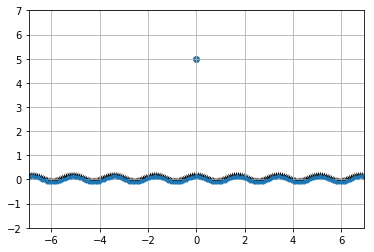

3.33281993866s
12.6001961231s


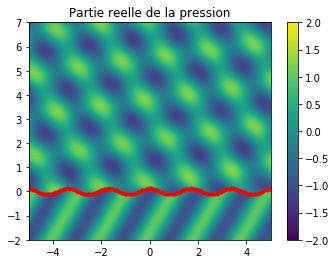

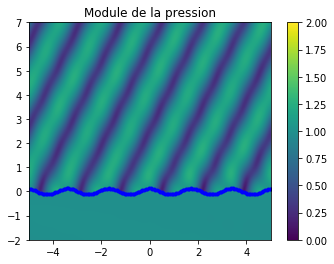

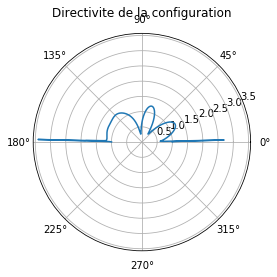

In [3]:
problem.create_interface('s_sinusoidale',.25,1.7,1500,50)
problem.set_source('plane',[0,5])
problem.set_frequency(200)
problem.set_omega([-5,5,-2,7],150,2)
problem.set_circle(2,[0,0])
problem.set_angle(np.pi/3)

p,d = problem.start()